In [1]:
import pandas as pd
from typing import Union, List, Optional
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt


def add_fdr_column(
    df: pd.DataFrame,
    p_col: str = "p_value",
    out_col: str = "p_value_adj",
    method: str = "fdr_bh",
    alpha: float = 0.05,
    inplace: bool = False,
) -> pd.DataFrame:
    """
    Add an FDR-adjusted p-value column to a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing raw p-values.
    p_col : str, default "p_value"
        Name of the column with raw p-values.
    out_col : str, default "p_value_adj"
        Name of the column to store adjusted p-values.
    method : str, default "fdr_bh"
        Correction method accepted by statsmodels.stats.multitest.multipletests
        (e.g., "fdr_bh", "fdr_by", "bonferroni", "holm").
    alpha : float, default 0.05
        Significance level used by multipletests when computing reject decisions
        (returned but not used further here).
    inplace : bool, default False
        If True, modify the original DataFrame; otherwise operate on a copy.

    Returns
    -------
    pd.DataFrame
        DataFrame with a new column containing FDR-adjusted p-values.
    """
    work_df: Union[pd.DataFrame, pd.core.generic.NDFrame]
    work_df = df if inplace else df.copy()

    # multipletests returns: reject, pvals_corrected, _, _
    _, qvals, _, _ = multipletests(
        work_df[p_col].astype(float).to_numpy(), alpha=alpha, method=method
    )
    work_df[out_col] = qvals
    return work_df

def plot_ratio_bars(
    df: pd.DataFrame,
    rows: List[int],
    ax: Optional[plt.Axes] = None,
    bar_kwargs: Optional[dict] = None,
    err_kwargs: Optional[dict] = None,
    label_rotation: int = 45,
    save_pdf: Optional[str] = None  # NEW: optionally save figure to this path
) -> plt.Axes:
    """
    Plot 'ratio_real' with error bars ('ratio_std') for the specified rows.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'ratio_real', 'ratio_std', 'cell_type1', 'cell_type2'.
    rows : list[int]
        Row indices to include in the plot.
    ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, a new figure/axis is created.
    bar_kwargs : dict, optional
        Extra kwargs forwarded to `ax.bar`.
    err_kwargs : dict, optional
        Keyword arguments forwarded to `ax.bar` via `error_kw`.
    label_rotation : int, default 45
        Rotation angle for x-axis tick labels.
    save_pdf : str or None, default None
        File path to save the figure as PDF. If None, figure is not saved.

    Returns
    -------
    matplotlib.axes.Axes
        Axis containing the bar plot.
    """
    if bar_kwargs is None:
        bar_kwargs = {}
    if err_kwargs is None:
        err_kwargs = dict(ecolor="black", capsize=3, lw=1)

    if ax is None:
        fig, ax = plt.subplots(figsize=(1.2 * len(rows) + 2, 6))
    else:
        fig = ax.figure

    sel = df.loc[rows]
    heights = sel["ratio_real"].to_numpy()
    errors = sel["ratio_std"].to_numpy()
    labels = (sel["cell_type1"] + "-" + sel["cell_type2"]).to_list()

    x = range(len(rows))
    ax.bar(
        x,
        heights,
        yerr=errors,
        error_kw=err_kwargs,
        **bar_kwargs,
    )
    ax.set_xticks(list(x))
    ax.set_xticklabels(labels, rotation=label_rotation, ha="right")
    ax.set_ylabel("ratio_real")
    ax.set_xlabel("CellType1-CellType2")
    ax.set_title("Ratio Real with Standard Deviation")
    ax.axhline(1, color="red", linestyle="--", linewidth=1)  # horizontal reference line
    ax.margins(y=0.1)

    if save_pdf is not None:                                  
        fig.savefig(save_pdf, format="pdf", bbox_inches="tight")

    return ax

In [2]:
CB = pd.read_csv('Cerebellum_proximity_scores.csv',index_col=0)
HP = pd.read_csv('Hippocampus_proximity_scores.csv',index_col=0)

In [3]:
add_fdr_column(CB, inplace=True, method="fdr_by")
add_fdr_column(HP, inplace=True, method="fdr_by")

,cell_type1,cell_type2,pval-adjusted_3,pval_3,z_score_3,contact_count_3,permutation_mean_3,permutation_std_3,region,age_3,...,permutation_std_24,age_24,z_statistic,p_value,p_value_adj,Region,ratio_real,ratio_mean,ratio_std,z_score
1387,DG Glut,DG Glut,1.670402e-72,2.890969e-76,18.444417,1796,907.444,48.174795,Hippocampus,3,...,101.555174,24,31.921071,1.112916e-03,1.745704e-01,Hippocampus,2.997773,3.741011,0.227966,-3.260307
1389,DG Glut,L2/3 IT CTX Glut,4.902955e-23,2.545667e-26,10.549785,426,247.809,16.890486,Hippocampus,3,...,38.552316,24,24.899015,1.540077e-03,2.214432e-01,Hippocampus,3.460094,4.561053,0.347632,-3.167024
1390,Ependymal NN,Ependymal NN,3.473188e-22,2.404422e-25,10.336685,326,123.026,19.636276,Hippocampus,3,...,5.264742,24,-13.477751,3.131848e-01,1.000000e+00,Hippocampus,0.159509,0.112692,0.046420,1.008562
1391,CA1-ProS Glut,DG Glut,9.075362e-17,7.853376e-20,9.039724,225,118.554,11.775359,Hippocampus,3,...,18.809567,24,5.632809,1.231960e-02,1.000000e+00,Hippocampus,1.555556,2.239368,0.273213,-2.502855
1392,DG Glut,IT EP-CLA Glut,7.460590e-15,7.747238e-18,8.523394,122,56.452,7.690364,Hippocampus,3,...,16.484192,24,11.599882,8.313516e-02,1.000000e+00,Hippocampus,2.729508,3.748884,0.588290,-1.732778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,CA1-ProS Glut,OPC NN,9.666556e-01,9.653172e-01,-1.816031,17,27.749,5.918953,Hippocampus,3,...,7.926440,24,5.256484,4.118679e-04,7.106551e-02,Hippocampus,4.058824,2.150204,0.540324,3.532360
2056,Astro-TE NN,MSN D1 Gaba,9.920101e-01,9.909800e-01,-2.364796,4,12.247,3.487405,Hippocampus,3,...,7.303867,24,6.424726,2.320366e-13,4.003663e-10,Hippocampus,14.000000,4.201927,1.336913,7.328877
2058,Astro-TE NN,CA1-ProS Glut,9.930611e-01,9.923736e-01,-2.426320,56,79.718,9.775299,Hippocampus,3,...,17.496963,24,7.434217,4.392025e-01,1.000000e+00,Hippocampus,3.660714,3.304260,0.460809,0.773541
2060,Ependymal NN,MH Tac2 Glut,9.990524e-01,9.987066e-01,-3.013007,71,121.911,16.897073,Hippocampus,3,...,6.827016,24,-3.292337,3.453233e-01,1.000000e+00,Hippocampus,0.154930,0.214780,0.063421,-0.943699


In [4]:
HP[((HP.cell_type1 == 'Microglia NN') | (HP.cell_type2 == 'Microglia NN'))]

,cell_type1,cell_type2,pval-adjusted_3,pval_3,z_score_3,contact_count_3,permutation_mean_3,permutation_std_3,region,age_3,...,permutation_std_24,age_24,z_statistic,p_value,p_value_adj,Region,ratio_real,ratio_mean,ratio_std,z_score
1419,Astro-TE NN,Microglia NN,0.000790,0.000005,4.420541,64,36.992,6.109659,Hippocampus,3,...,17.465076,24,13.079040,0.066148,1.000000,Hippocampus,4.781250,7.105536,1.264973,-1.837420
1434,Microglia NN,Microglia NN,0.004774,0.000047,3.905102,34,13.564,5.233154,Hippocampus,3,...,11.817238,24,5.570977,0.351119,1.000000,Hippocampus,3.117647,5.135948,2.164581,-0.932421
1435,L2/3 IT CTX Glut,Microglia NN,0.004968,0.000050,3.891216,58,34.185,6.120194,Hippocampus,3,...,13.674078,24,9.144778,0.063919,1.000000,Hippocampus,3.362069,5.256662,1.022588,-1.852743
1453,L6 CT CTX Glut,Microglia NN,0.020658,0.000365,3.378298,15,6.525,2.508660,Hippocampus,3,...,6.685809,24,4.201112,0.162472,1.000000,Hippocampus,3.000000,7.045057,2.895936,-1.396805
1493,Microglia NN,Oligo NN,0.071337,0.002148,2.855530,36,22.393,4.765139,Hippocampus,3,...,12.351128,24,10.952933,0.283602,1.000000,Hippocampus,5.027778,6.658018,1.520375,-1.072262
1513,DG Glut,Microglia NN,0.132234,0.004585,2.605680,52,35.660,6.270917,Hippocampus,3,...,18.524360,24,7.311959,0.019877,1.000000,Hippocampus,3.750000,6.777622,1.300151,-2.328669
1525,MOB-in Frmd7 Gaba,Microglia NN,0.179956,0.006976,2.458472,19,10.809,3.331744,Hippocampus,3,...,5.191500,24,2.593762,0.496995,1.000000,Hippocampus,1.842105,2.449995,0.894976,-0.679225
1565,CA1-ProS Glut,Microglia NN,0.282750,0.014030,2.196455,41,28.332,5.767476,Hippocampus,3,...,9.903076,24,3.839396,0.147356,1.000000,Hippocampus,2.073171,3.124841,0.725824,-1.448934
1574,CB Granule Glut,Microglia NN,0.328961,0.016966,2.120876,9,4.510,2.117050,Hippocampus,3,...,5.104976,24,4.342679,0.441926,1.000000,Hippocampus,3.666667,6.001109,3.035904,-0.768945
1665,BAM NN,Microglia NN,0.710324,0.061950,1.538608,2,0.737,0.820872,Hippocampus,3,...,2.433305,24,3.115222,0.730896,1.000000,Hippocampus,5.000000,8.419267,9.941648,-0.343934


In [5]:
CB[((CB.cell_type1 == 'Microglia NN') | (CB.cell_type2 == 'Microglia NN'))]

,cell_type1,cell_type2,pval-adjusted_3,pval_3,z_score_3,contact_count_3,permutation_mean_3,permutation_std_3,region,age_3,...,permutation_std_24,age_24,z_statistic,p_value,p_value_adj,Region,ratio_real,ratio_mean,ratio_std,z_score
22,CBX MLI Megf11 Gaba,Microglia NN,1.305154e-25,1.180670e-28,11.043324,2080,1581.978,45.097112,Cerebellum,3,...,39.666199,24,-8.841216,4.393628e-02,1.000000,Cerebellum,0.744712,0.813522,0.034154,-2.014698
52,Astro-NT NN,Microglia NN,2.487960e-08,5.186307e-11,6.461418,932,743.261,29.210150,Cerebellum,3,...,20.612951,24,-10.209534,1.310737e-01,1.000000,Cerebellum,0.608369,0.555093,0.035285,1.509881
71,Microglia NN,Microglia NN,1.617424e-04,4.898393e-07,4.895677,324,222.558,20.720730,Cerebellum,3,...,25.250224,24,9.796784,9.726032e-04,0.126496,Cerebellum,1.987654,1.414355,0.173815,3.298334
75,Bergmann NN,Microglia NN,1.958102e-03,6.623275e-06,4.355992,427,344.362,18.971108,Cerebellum,3,...,13.395414,24,-7.879883,2.185821e-01,1.000000,Cerebellum,0.571429,0.512301,0.048059,1.230307
77,Microglia NN,Oligo NN,2.208350e-03,7.649175e-06,4.324348,951,824.014,29.365350,Cerebellum,3,...,24.111773,24,-6.237487,6.971536e-03,0.680035,Cerebellum,0.750789,0.650086,0.037322,2.698201
80,MOB-in Frmd7 Gaba,Microglia NN,2.945657e-03,1.065882e-05,4.250623,39,20.169,4.430174,Cerebellum,3,...,3.684484,24,-4.165144,1.919365e-01,1.000000,Cerebellum,0.384615,0.695325,0.238115,-1.304872
145,CBX MLI Cdh22 Gaba,Microglia NN,8.208002e-02,1.075030e-03,3.068681,259,214.352,14.549574,Cerebellum,3,...,12.497282,24,-3.701774,7.465603e-01,1.000000,Cerebellum,0.725869,0.750896,0.077440,-0.323178
182,MOB Trdn Gaba,Microglia NN,2.691923e-01,4.499773e-03,2.612071,25,14.782,3.911838,Cerebellum,3,...,2.729696,24,-4.402437,1.183012e-01,1.000000,Cerebellum,0.160000,0.519618,0.230238,-1.561944
228,Endo NN,Microglia NN,5.390174e-01,1.163896e-02,2.268842,330,291.164,17.117100,Cerebellum,3,...,18.235961,24,2.598866,3.941494e-01,1.000000,Cerebellum,1.196970,1.119551,0.090854,0.852117
427,IC Tfap2d Maf Glut,Microglia NN,6.568749e-01,8.320172e-02,1.383853,17,12.274,3.415102,Cerebellum,3,...,4.383825,24,4.138884,1.934517e-01,1.000000,Cerebellum,2.352941,1.608359,0.572564,1.300436


<Axes: title={'center': 'Ratio Real with Standard Deviation'}, xlabel='CellType1-CellType2', ylabel='ratio_real'>

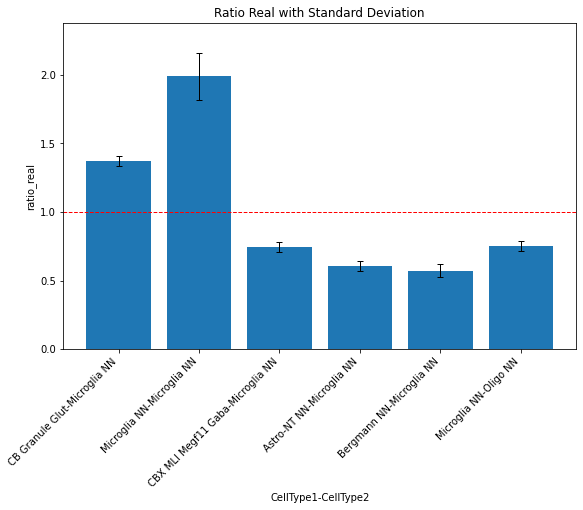

In [6]:
plot_ratio_bars(
    CB[((CB.cell_type1 == 'Microglia NN') | (CB.cell_type2 == 'Microglia NN'))],
    [1378, 71, 22, 52, 75, 77],
    save_pdf='figures/CB_proximity_plot.pdf'
)

<Axes: title={'center': 'Ratio Real with Standard Deviation'}, xlabel='CellType1-CellType2', ylabel='ratio_real'>

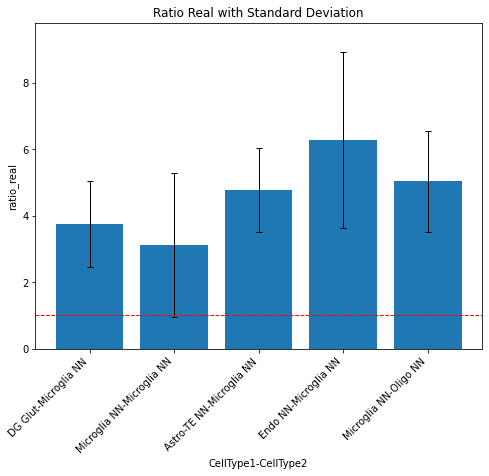

In [7]:
plot_ratio_bars(
    HP[((HP.cell_type1 == 'Microglia NN') | (HP.cell_type2 == 'Microglia NN'))],
    [1513, 1434,1419, 1667, 1493],
    save_pdf='figures/HP_proximity_plot.pdf'
)